In [1]:
cd /home/makinen/repositories/fishnets

/home/makinen/repositories/fishnets


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tqdm import trange
from scipy import stats
tfk = tf.keras

from fishnets import *

/softs/python/py3mods/tensorflow/2.8.3/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Create training data

In [9]:
# data sizes
n_sims = 1000
n_data = 100000

# fiducial parameters
theta_fid = tf.constant([0.,0.], dtype=tf.float32)
theta_fid_ = theta_fid.numpy()

# prior mean and covariance
priorCinv = tf.convert_to_tensor(np.eye(2), dtype=tf.float32)
priormu = tf.constant([0.,0.], dtype=tf.float32)

# slopes and intercepts
m_ = np.random.normal(0, 1, n_sims).astype(np.float32)
c_ = np.random.normal(0, 1, n_sims).astype(np.float32)

# x-values
x_ = np.random.uniform(0, 10, (n_sims, n_data)).astype(np.float32)

# noise std devs
sigma_ = np.random.uniform(1, 10, (n_sims, n_data)).astype(np.float32)

# simulate "data"
y_ = m_[...,np.newaxis]*x_ + c_[...,np.newaxis] + np.random.normal(0, 1, sigma_.shape)*sigma_
y_ = y_.astype(np.float32)

# put in some "inductive biases"
x1_ = x_*(1./ sigma_**2)
x2_ = y_*(1./ sigma_**2)

# stack up the data and parameters
data = tf.stack([y_, x_, 1./sigma_**2, x1_, x2_], axis=-1)
theta = tf.stack([m_, c_], axis=-1)

# # stack up the data and parameters
# data = tf.stack([y_, x_, 1./sigma_**2], axis=-1)
# theta = tf.stack([m_, c_], axis=-1)

Create the masks if we want to train over variable N

In [4]:
# construct masks
score_mask = np.ones((n_sims, n_data, 2))
fisher_mask = np.ones((n_sims, n_data, 2, 2))

# mask or not?
masked = True

# make the masks
if masked is True:
    for i in range(n_sims):
        
        # how many points to mask?
        n_mask = np.random.randint(1, n_data-5)
        
        # choose which points to mask
        idx = np.random.choice(np.arange(n_data), n_mask, replace=False)
        
        # mask those points (set the fisher and score masks to zero for those points)
        for j in idx:
            score_mask[i,j,:] = 0
            fisher_mask[i,j,...] = 0

score_mask = tf.convert_to_tensor(score_mask, dtype=tf.float32)
fisher_mask = tf.convert_to_tensor(fisher_mask, dtype=tf.float32)

In [7]:
###### save all the data
outdir = "/data80/makinen/fishnets/"

np.save(outdir + "data", data.numpy())
np.save(outdir + "theta", theta.numpy())
np.save(outdir + "score_mask", score_mask)
np.save(outdir + "fisher_mask", fisher_mask)

Construct the exact MLEs for comparison

In [5]:
# compute MLEs
F_ = np.sum(np.stack([x_**2 / sigma_**2, x_ / sigma_**2, x_ / sigma_**2, 1. / sigma_**2], axis=-1).reshape((n_sims, n_data, 2, 2)) * fisher_mask.numpy(), axis=1) + priorCinv.numpy()
t_ = np.sum(np.stack([x_*(y_ - (theta_fid[0]*x_ + theta_fid[1]))/ sigma_**2, (y_ - (theta_fid[0]*x_ + theta_fid[1])) / sigma_**2], axis=-1) * score_mask.numpy(), axis=1) - np.dot(priorCinv, theta_fid - priormu)
pmle_ = theta_fid_ + np.einsum('ijk,ik->ij', np.linalg.inv(F_), t_)

Make the Fishnet model

In [7]:
Model = FishnetTwin(n_parameters=2, 
                n_inputs=5, 
                n_hidden_score=[64, 64], 
                activation_score=[tf.nn.elu, tf.nn.elu],
                n_hidden_fisher=[64, 64], 
                activation_fisher=[tf.nn.elu, tf.nn.elu],
                optimizer=tf.keras.optimizers.Adam(lr=5e-4),
                theta_fid=theta_fid,
                priormu=tf.zeros(2, dtype=tf.float32),
                priorCinv=tf.eye(2, dtype=tf.float32))

Train the model

In [8]:
Model.train((data, theta, score_mask, fisher_mask), lr=5e-4, epochs=500)
Model.train((data, theta, score_mask, fisher_mask), lr=1e-4, epochs=500)
Model.train((data, theta, score_mask, fisher_mask), lr=5e-5, epochs=500)

100%|██████████| 500/500 [15:03<00:00,  1.81s/it, loss=-2.8] 


[-2.7644982,
 -2.864443,
 -2.889743,
 -2.9034252,
 -2.7106643,
 -2.7746553,
 -2.8418028,
 -2.8083582,
 -2.8012657,
 -2.8073323,
 -2.8540115,
 -2.8308082,
 -2.7800357,
 -2.8078806,
 -2.7903352,
 -2.8711274,
 -2.820181,
 -2.7741628,
 -2.7913654,
 -2.7006664,
 -2.7863908,
 -2.7893429,
 -2.8527255,
 -2.8915403,
 -2.8634217,
 -2.8440306,
 -2.741486,
 -2.7355926,
 -2.7570407,
 -2.777257,
 -2.7667432,
 -2.783204,
 -2.8404226,
 -2.8504527,
 -2.6765375,
 -2.819252,
 -2.7599,
 -2.7893906,
 -2.8655777,
 -2.831149,
 -2.8160467,
 -2.7806344,
 -2.815485,
 -2.7992597,
 -2.8226805,
 -2.7932296,
 -2.888481,
 -2.693145,
 -2.8147092,
 -2.8692846,
 -2.8619542,
 -2.7899632,
 -2.7442331,
 -2.8676007,
 -2.74586,
 -2.841775,
 -2.7113397,
 -2.7637005,
 -2.790147,
 -2.8859773,
 -2.7769933,
 -2.7649708,
 -2.806585,
 -2.908852,
 -2.9046257,
 -2.784807,
 -2.8137088,
 -2.855464,
 -2.7799935,
 -2.8494782,
 -2.7339,
 -2.8532293,
 -2.7974582,
 -2.8116422,
 -2.73889,
 -2.803734,
 -2.7213635,
 -2.8104777,
 -2.8177063,
 

In [16]:
Model.stitch_idx

ListWrapper([<tf.Tensor: shape=(64, 3), dtype=int32, numpy=
array([[  0,   1,   2],
       [  3,   4,   5],
       [  6,   7,   8],
       [  9,  10,  11],
       [ 12,  13,  14],
       [ 15,  16,  17],
       [ 18,  19,  20],
       [ 21,  22,  23],
       [ 24,  25,  26],
       [ 27,  28,  29],
       [ 30,  31,  32],
       [ 33,  34,  35],
       [ 36,  37,  38],
       [ 39,  40,  41],
       [ 42,  43,  44],
       [ 45,  46,  47],
       [ 48,  49,  50],
       [ 51,  52,  53],
       [ 54,  55,  56],
       [ 57,  58,  59],
       [ 60,  61,  62],
       [ 63,  64,  65],
       [ 66,  67,  68],
       [ 69,  70,  71],
       [ 72,  73,  74],
       [ 75,  76,  77],
       [ 78,  79,  80],
       [ 81,  82,  83],
       [ 84,  85,  86],
       [ 87,  88,  89],
       [ 90,  91,  92],
       [ 93,  94,  95],
       [ 96,  97,  98],
       [ 99, 100, 101],
       [102, 103, 104],
       [105, 106, 107],
       [108, 109, 110],
       [111, 112, 113],
       [114, 115, 116],
    

In [19]:
# run lbfgs optimizer
def lbfgs_optimize(Model, inputs, parameters, score_mask, fisher_mask, max_iterations=500, tolerance=1e-5, verbose=True):
    
    # initial parameters
    initial_parameters = tf.dynamic_stitch(Model.stitch_idx, Model.trainable_variables)
    
    # value and gradients function, as required by l-bfgs
    def value_and_gradient(x):
        
        # set the updated network parameters
        Model.assign_new_model_parameters(x)
        
        # compute loss and gradients (using gradient accumulation if needed)
        loss, gradients = Model.compute_loss_and_gradients(inputs, parameters, score_mask, fisher_mask)
        gradients = tf.dynamic_stitch(Model.stitch_idx, gradients) # stitch the gradients together into 1d, as needed by l-bfgs
        
        # print the loss if desired
        if verbose:
            print(loss.numpy())
        
        return loss, gradients
    
    # run the optimizer
    results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=value_and_gradient,
                                            initial_position=initial_parameters,
                                            max_iterations=max_iterations,
                                            tolerance=tolerance)
    
    return results

In [22]:
import tensorflow as tf
import tensorflow_probability as tfp

ndims = 60
minimum = tf.ones([ndims], dtype="float64")
scales = tf.range(ndims, dtype="float64") + 1.0


def quadratic(x):
    value = tf.reduce_sum(scales * (x - minimum) ** 2)
    return value


start = tf.range(ndims, 0, -1, dtype="float64")

optim_results = tfp.optimizer.lbfgs_minimize(
    lambda x: tfp.math.value_and_gradient(quadratic, x),
    initial_position=start,
    num_correction_pairs=10,
    tolerance=1e-8,
)

In [24]:
%xmode verbose

Exception reporting mode: Verbose


In [28]:
lbfgs_optimize(Model, data, theta, score_mask, fisher_mask, max_iterations=10, tolerance=1e-5)

0.27304044
3.7037283e+17


Exception: <class 'TypeError'>

In [ ]:
Model.lbfgs_optimize(data, theta, score_mask, fisher_mask, max_iterations=10, tolerance=1e-5)

-2.2533057
18810738000000.0


Exception: <class 'TypeError'>

Compute model predictions to compare to exact MLEs

100%|██████████| 50/50 [00:03<00:00, 14.13it/s]


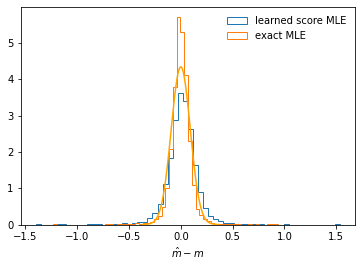

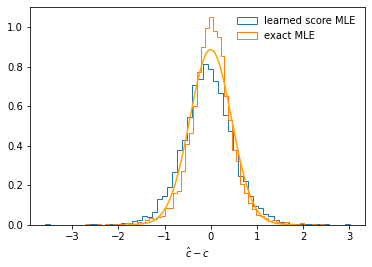

In [14]:
# model MLEs
mle, F = Model.compute_mle_(data, score_mask, fisher_mask)

plt.hist(mle[:,0].numpy() - theta[:,0].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.hist(pmle_[:,0] - theta[:,0].numpy(), bins = 60, histtype='step', density=True, label='exact MLE')
std = np.std(pmle_[:,0] - theta[:,0].numpy())
x = np.linspace(-4*std, 4*std, 500)
plt.plot(x, stats.norm.pdf(x, loc=0, scale=std), color='orange')
#plt.axvline(np.mean(mle[:,0].numpy() - theta[:,0].numpy()))
#plt.axvline(np.mean(pmle_[:,0] - theta[:,0].numpy()))
plt.xlabel('$\hat{m} - m$')
plt.legend(frameon=False)
plt.show()

plt.hist(mle[:,1].numpy() - theta[:,1].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.hist(pmle_[:,1] - theta[:,1].numpy(), bins = 60, histtype='step', density=True, label='exact MLE')
std = np.std(pmle_[:,1] - theta[:,1].numpy())
x = np.linspace(-4*std, 4*std, 500)
plt.plot(x, stats.norm.pdf(x, loc=0, scale=std), color='orange')
#plt.axvline(np.mean(mle[:,1].numpy() - theta[:,1].numpy()), color='blue')
#plt.axvline(np.mean(pmle_[:,1] - theta[:,1].numpy()), color='orange')
plt.xlabel('$\hat{c} - c$')
plt.legend(frameon=False)
plt.show()

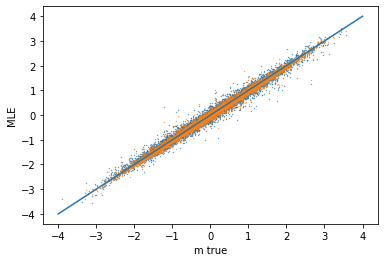

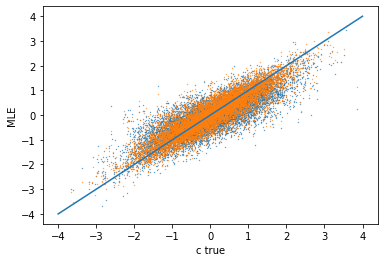

In [15]:
# predicted (blue) vs true (orange) MLEs
x = np.linspace(-4,4,100)
plt.scatter(theta[:,0].numpy(), mle[:,0].numpy(), s = 0.1)
plt.scatter(theta[:,0].numpy(), pmle_[:,0], s = 0.1)
plt.plot(x,x)
plt.xlabel('m true')
plt.ylabel('MLE')
plt.show()

plt.scatter(theta[:,1].numpy(), mle[:,1].numpy(), s = 0.1)
plt.scatter(theta[:,1].numpy(), pmle_[:,1], s = 0.1)
plt.plot(x,x)
plt.xlabel('c true')
plt.ylabel('MLE')
plt.show()